# Madhav Labs Recruitment Task 1

**Train a small CNN for classificying the instruments being played, given an audio file from this dataset for 30 epochs. You are free to choose all other hyperparmeters. Save this trained model.**

This approach is inspired from [this paper](https://drive.google.com/file/d/1tvrxrDhTmPCPsZw6OfhLM7P-aRaREpxL/view?usp=sharing)



## DataSet Loading

In [ ]:
!pip install python_speech_features
!pip install -q tensorflow-model-optimization


In [ ]:
!wget https://zenodo.org/records/3685367/files/TinySOL.tar.gz
!wget https://zenodo.org/records/3685367/files/TinySOL_metadata.csv
!tar -xvzf TinySOL.tar.gz

--2024-02-06 00:49:57--  https://zenodo.org/records/3685367/files/TinySOL.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.98.238, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1026917185 (979M) [application/octet-stream]
Saving to: ‘TinySOL.tar.gz’

TinySOL.tar.gz      100%[===================>] 979.34M  18.2MB/s    in 56s     

2024-02-06 00:50:55 (17.4 MB/s) - ‘TinySOL.tar.gz’ saved [1026917185/1026917185]

--2024-02-06 00:50:55--  https://zenodo.org/records/3685367/files/TinySOL_metadata.csv
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 317576 (310K) [text/plain]
Saving to: ‘TinySOL_metadata.csv’

TinySOL_metadata.cs 100%[===================>] 310.13K   488KB/s    in 0.6s    

2024-02-06 00:50:

## Importing Necessary Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import librosa
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from python_speech_features import mfcc
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout,LSTM,Concatenate,Activation,Input
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras.models import Sequential

import tensorflow as tf
import tensorflow_model_optimization as tfmot
from sklearn.metrics import accuracy_score,classification_report
import tempfile

In [ ]:
df = pd.read_csv("/content/TinySOL_metadata.csv")

In [ ]:
df

,Path,Fold,Family,Instrument (abbr.),Instrument (in full),Technique (abbr.),Technique (in full),Pitch,Pitch ID,Dynamics,Dynamics ID,Instance ID,String ID (if applicable),Needed digital retuning
0,Brass/Bass_Tuba/ordinario/BTb-ord-F#1-pp-N-N.wav,2,Brass,BTb,Bass Tuba,ord,ordinario,F#1,30,pp,0,0,NaN,False
1,Brass/Bass_Tuba/ordinario/BTb-ord-G1-pp-N-R100...,4,Brass,BTb,Bass Tuba,ord,ordinario,G1,31,pp,0,0,NaN,True
2,Brass/Bass_Tuba/ordinario/BTb-ord-G#1-pp-N-T16...,3,Brass,BTb,Bass Tuba,ord,ordinario,G#1,32,pp,0,0,NaN,True
3,Brass/Bass_Tuba/ordinario/BTb-ord-A1-pp-N-T23d...,2,Brass,BTb,Bass Tuba,ord,ordinario,A1,33,pp,0,0,NaN,True
4,Brass/Bass_Tuba/ordinario/BTb-ord-A#1-pp-N-N.wav,0,Brass,BTb,Bass Tuba,ord,ordinario,A#1,34,pp,0,0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2908,Winds/Oboe/ordinario/Ob-ord-F6-ff-N-N.wav,2,Winds,Ob,Oboe,ord,ordinario,F6,89,ff,4,0,NaN,False
2909,Winds/Oboe/ordinario/Ob-ord-F#6-ff-N-T12u.wav,0,Winds,Ob,Oboe,ord,ordinario,F#6,90,ff,4,0,NaN,True
2910,Winds/Oboe/ordinario/Ob-ord-G6-ff-N-T16u.wav,0,Winds,Ob,Oboe,ord,ordinario,G6,91,ff,4,0,NaN,True
2911,Winds/Oboe/ordinario/Ob-ord-G#6-ff-N-N.wav,0,Winds,Ob,Oboe,ord,ordinario,G#6,92,ff,4,0,NaN,False


In [ ]:
df = df.drop(["String ID (if applicable)","Needed digital retuning","Instance ID","Dynamics ID","Dynamics","Technique (in full)","Instrument (abbr.)","Technique (abbr.)","Fold"],axis = 1)

In [ ]:
df.shape

(2913, 5)

In [ ]:
df['Instrument (in full)'].value_counts().sum()

2913

In [ ]:
df['Instrument (in full)'].nunique() # Number of Instruments in the dataset (Target Variables)

14

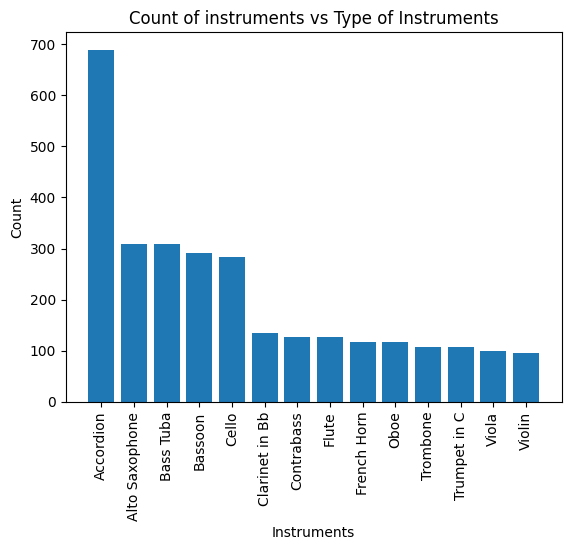

In [ ]:
#Plot to show the distribution of classes individually
plt.bar(np.unique(df["Instrument (in full)"].values),df["Instrument (in full)"].value_counts())
plt.ylabel('Count')
plt.xlabel('Instruments')
plt.xticks(rotation=90)
plt.title('Count of instruments vs Type of Instruments')
plt.show()

In [ ]:
#Collecting the Audio data from the .wav files
#Librosa is used to directly load the .wav file into numy array format

audio_data = list()
for i in tqdm(range(df.shape[0])):
    audio_data.append(librosa.load(df["Path"][i]))
audio_data = np.array(audio_data)

100%|██████████| 2913/2913 [00:12<00:00, 225.59it/s]
<ipython-input-10-4a131eb3c136>:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  audio_data = np.array(audio_data)


In [ ]:
#The audio data and corresponding Sample frequency is stored in the dataframe
df['audio_waves'] = audio_data[:,0]
df['samplerate'] = audio_data[:,1]

In [ ]:
#Bit lengths - Length of the sampled audio data
#Second length- Length if the audio ins Seconds
bit_lengths = list()
for i in range(df.shape[0]):
    bit_lengths.append(len(df['audio_waves'].iloc[i]))
bit_lengths = np.array(bit_lengths)
df['bit_lengths'] = bit_lengths
df['seconds_length'] = df['bit_lengths']/df['samplerate']

In [ ]:
#Outlier Removal-I
#We remove the parts of data with length of audio < 2 seconds
#This is reasoned out because it is difficult for a model to learn/identify without sufficient second lengths
df = df[df['seconds_length'] >= 2.0]

In [ ]:
#df['seconds_length'].max()
#Identifying the Minnimum of length of Bits and Length in seconds of the audio data
min_bits = np.min(df['bit_lengths'])
print('Minimum Bit Length: {}'.format(min_bits))

min_seconds = np.min(df['seconds_length'])
print('Minimum Seconds length: {}'.format(min_seconds))

Minimum Bit Length: 49657
Minimum Seconds length: 2.252018140589569


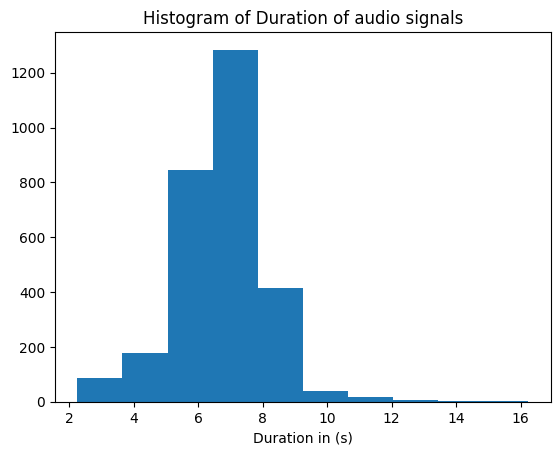

In [ ]:
plt.hist(df['seconds_length'])
plt.title('Histogram of Duration of audio signals')
plt.xlabel('Duration in (s)')
#plt.grid()
plt.show()

## Data Preprocessing

In [ ]:
#Generating audio waves and setting up correspnding labels
#Num samples to be generated is a hyper parameter

num_samples = 6000
generated_audio_waves = list()
generated_audio_labels = list()
for i in tqdm(range(num_samples)):
    try:
        chosen_file = np.random.choice(df["Path"].values)
        chosen_initial = np.random.choice(np.arange(0,df[df["Path"]==chosen_file]['bit_lengths'].values-min_bits))
        generated_audio_waves.append(df[df["Path"]==chosen_file]['audio_waves'].values[0][chosen_initial:chosen_initial+min_bits])

        generated_audio_labels.append(df[df["Path"]==chosen_file]["Instrument (in full)"].values)
    except ValueError:
        continue
generated_audio_waves = np.array(generated_audio_waves)
generated_audio_labels = np.array(generated_audio_labels)

100%|██████████| 6000/6000 [00:16<00:00, 355.33it/s]


In [ ]:
#Converting the label names into Integers
# The 14 instruments available in the dataset are converted into intergers from 0-13
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(generated_audio_labels)

label_encoded = label_encoded[:, np.newaxis]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
#Converting the labels into one hot encoded form
#This converts each label from its integer represntation to 1*14 vector form
# Label 3 becomes - [0,0,0,1,0,0,0,0,0,0,0,0,0,0]
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoded = one_hot_encoder.fit_transform(label_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
#Generating the MFCC features from the generated Audio waves data
#We make use of the Python_speech_ features for conversion
mfcc_features = list()
for i in tqdm(range(len(generated_audio_waves))):
    mfcc_features.append(mfcc(generated_audio_waves[i]))
mfcc_features = np.array(mfcc_features)

100%|██████████| 5998/5998 [00:45<00:00, 131.39it/s]


In [ ]:
print(generated_audio_waves.shape)
print(mfcc_features.shape)

(5998, 49657)
(5998, 309, 13)


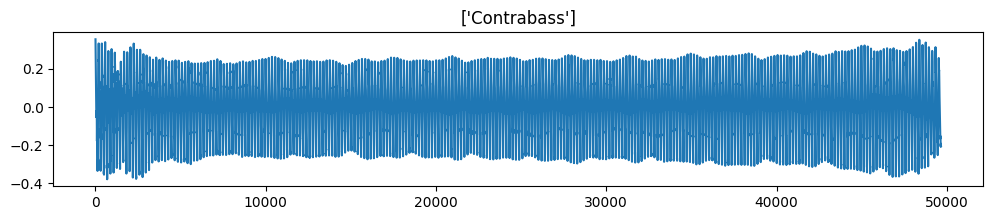

In [ ]:
# Sample Plot of generated Audiowave data
plt.figure(figsize=(12,2))
plt.plot(generated_audio_waves[10])
plt.title(generated_audio_labels[10])
plt.show()

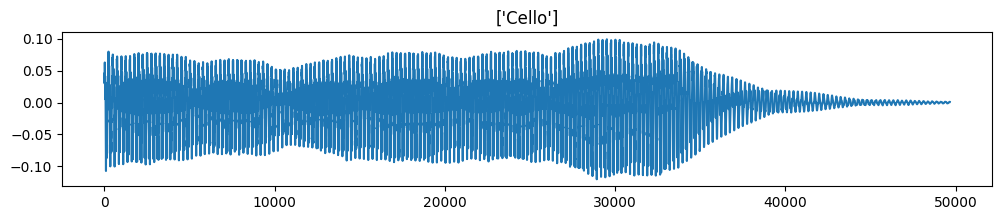

In [ ]:
# Sample Plot of generated Audiowave data
plt.figure(figsize=(12,2))
plt.plot(generated_audio_waves[11])
plt.title(generated_audio_labels[11])
plt.show()

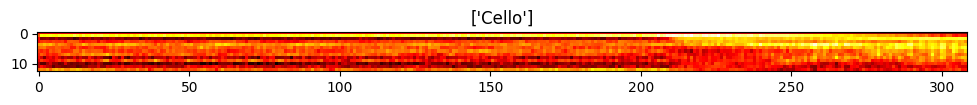

In [ ]:
#Sample plot of corresponding MFCC feature plot
plt.figure(figsize=(12, 2))
plt.imshow(mfcc_features[11].T, cmap='hot')
plt.title(generated_audio_labels[11])
plt.show()

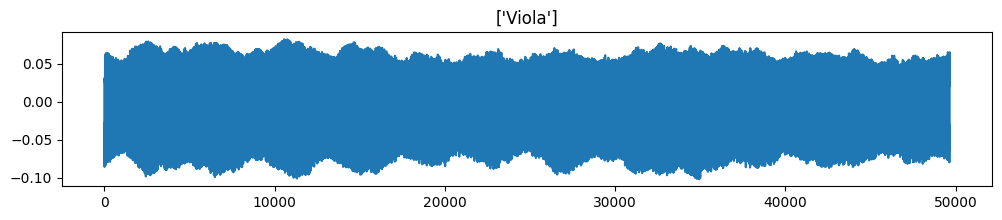

In [ ]:
# Sample Plot of generated Audiowave data
plt.figure(figsize=(12,2))
plt.plot(generated_audio_waves[12])
plt.title(generated_audio_labels[12])
plt.show()

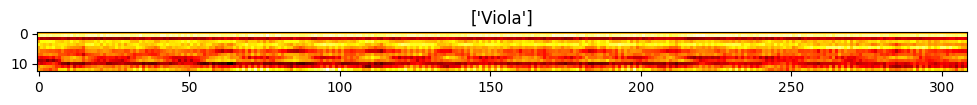

In [ ]:
#Sample plot of corresponding MFCC feature plot
plt.figure(figsize=(12, 2))
plt.imshow(mfcc_features[12].T, cmap='hot')
plt.title(generated_audio_labels[12])
plt.show()

In [ ]:
#Forming the dependent and independent variables for model creation
#X is the input to the model
#y is expected output (Ground truth values)
X = mfcc_features
y = one_hot_encoded

In [ ]:
#Data scaling
#Using Range scaling operation
#This converts the input array values between [0,1]
X = (X-X.min())/(X.max()-X.min())

In [ ]:
#Splitting the data into train and test sets
#Train- 0.8, Test -0.2
#Random state is fixed to replicate the split in the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [ ]:
#Shape of the input data into the CNN model
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [ ]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_test.shape)

(4798, 309, 13, 1)
(1200, 309, 13, 1)


## CutMix Algorithm

As proposed in the paper

In [ ]:
#Generation of random subspace within the input 2D array
def rand_bbox(size, lamb):
    """ Generate random subspace
    Args:
        - size: width,height of the subspace
        - lamb: (lambda) cut ratio parameter
    Returns:
        - Bounding interval
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int64(W * cut_rat)
    cut_h = np.int64(H * cut_rat)


    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)


    return bbx1, bby1, bbx2, bby2

In [ ]:
def generate_cutmix_image(image_batch, image_batch_labels, beta):
    # generate mixed sample
    #We sample out the lambda parameter from a Beta distribution
    lam = np.random.beta(beta, beta)
    #We choose a random audio element to make perturbations with
    rand_index = np.random.permutation(len(image_batch))
    #Taget a - Label of original audio
    #Target b- Label of Randomly picked audio
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    #We obtain the region to perturbed in the original audio
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0].shape, lam)

    image_batch_updated = image_batch.copy()
    image_batch_updated[:, bbx1:bbx2, bby1:bby2, :] = image_batch[rand_index, bbx1:bbx2, bby1:bby2, :]

    # adjusting lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[1] * image_batch.shape[2]))
    label = target_a * lam + target_b * (1. - lam)

    return image_batch_updated, label

In [ ]:
def gendata(X_train,y_train,beta=1):
  X_aug,y_aug=generate_cutmix_image(X_train,y_train,beta)
  return(X_aug,y_aug)

In [ ]:
#Betas is a hyperparameter list
#We sample out different betas to get different lambdas and different perturbed audio signals
betas=[1,0.9,0.8]
i=0
for beta in betas:
  X_train1,y_train1=gendata(X_train,y_train,beta)
  if(i==0):
    Xs=X_train1
    ys=y_train1
    i+=1
  else:
    Xs=np.vstack([Xs,X_train1])
    ys=np.vstack([ys,y_train1])

In [ ]:
#Augmenting the perturbed audio signals with the oroginal train data
#This helps us increase the available train data by 3 folds
X_train=np.vstack([X_train,Xs])
y_train=np.vstack([y_train,ys])

In [ ]:
X_train.shape, y_train.shape

((19192, 309, 13, 1), (19192, 14))

In [ ]:
#Building CNN model

model_cutmix = Sequential()
model_cutmix .add(Conv2D(40, (1, 1), activation='relu', input_shape=input_shape))
model_cutmix .add(Dropout(0.2))
model_cutmix .add(Conv2D(32, (5, 5), activation='relu'))
model_cutmix .add(Dropout(0.2))
model_cutmix .add(Conv2D(16, (1, 1), activation='relu'))
model_cutmix .add(Dropout(0.2))
model_cutmix .add(Flatten())
model_cutmix .add(Dense(64, activation='relu'))
model_cutmix .add(Dropout(0.2))
model_cutmix .add(Dense(32, activation='relu'))
model_cutmix .add(Dropout(0.2))
model_cutmix .add(Dense(16, activation='relu'))
model_cutmix .add(Dropout(0.1))
model_cutmix .add(Dense(14, activation='softmax'))

model_cutmix .compile(loss='categorical_crossentropy',
     optimizer='adam',
     metrics=['accuracy'])

In [ ]:
model_cutmix.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 309, 13, 40)       80        
                                                                 
 dropout (Dropout)           (None, 309, 13, 40)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 305, 9, 32)        32032     
                                                                 
 dropout_1 (Dropout)         (None, 305, 9, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 305, 9, 16)        528       
                                                                 
 dropout_2 (Dropout)         (None, 305, 9, 16)        0         
                                                                 
 flatten (Flatten)           (None, 43920)             0

In [ ]:
#Training the data for 30 epochs
#Using Model checkpoints to avoid overfitting
#Using a validation split of 0.2 from the train data

checkpoint_filepath = '/tmp/checkpoint'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

history_cutmix =model_cutmix .fit(X_train,y_train,epochs=30,batch_size=16,
          callbacks=[model_checkpoint_callback],
          #validation_split=0.2
          validation_data=(X_test,y_test))

model_cutmix .load_weights(checkpoint_filepath)

Epoch 1/30
1200/1200 [==============================] - 16s 9ms/step - loss: 1.9460 - accuracy: 0.4066 - val_loss: 1.2396 - val_accuracy: 0.5933
Epoch 2/30
1200/1200 [==============================] - 10s 9ms/step - loss: 1.5895 - accuracy: 0.5822 - val_loss: 1.0329 - val_accuracy: 0.6792
Epoch 3/30
1200/1200 [==============================] - 10s 9ms/step - loss: 1.4846 - accuracy: 0.6350 - val_loss: 0.9698 - val_accuracy: 0.7158
Epoch 4/30
1200/1200 [==============================] - 10s 9ms/step - loss: 1.4074 - accuracy: 0.6692 - val_loss: 0.9034 - val_accuracy: 0.7150
Epoch 5/30
1200/1200 [==============================] - 11s 9ms/step - loss: 1.3425 - accuracy: 0.6980 - val_loss: 0.8235 - val_accuracy: 0.7483
Epoch 6/30
1200/1200 [==============================] - 11s 9ms/step - loss: 1.3095 - accuracy: 0.7194 - val_loss: 0.7891 - val_accuracy: 0.7683
Epoch 7/30
1200/1200 [==============================] - 11s 9ms/step - loss: 1.2776 - accuracy: 0.7315 - val_loss: 0.7844 - val_ac

loss: 1.0989406108856201
val_loss: 0.7560985088348389


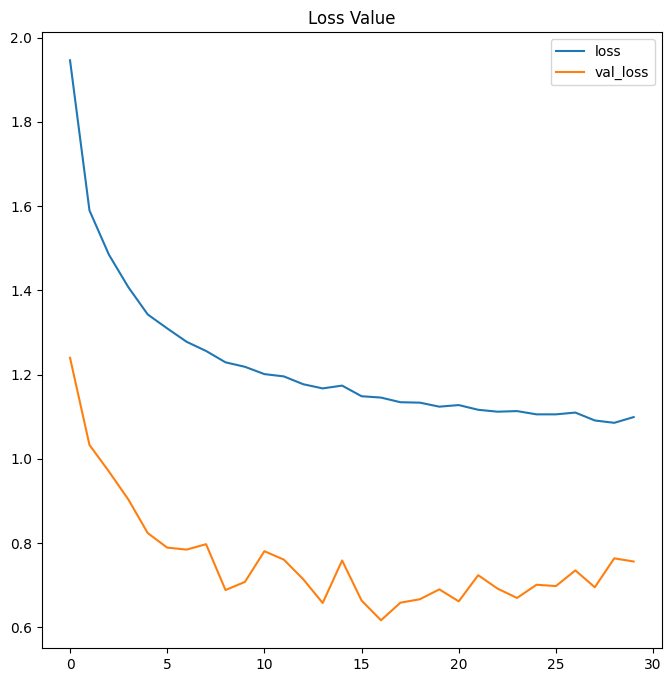

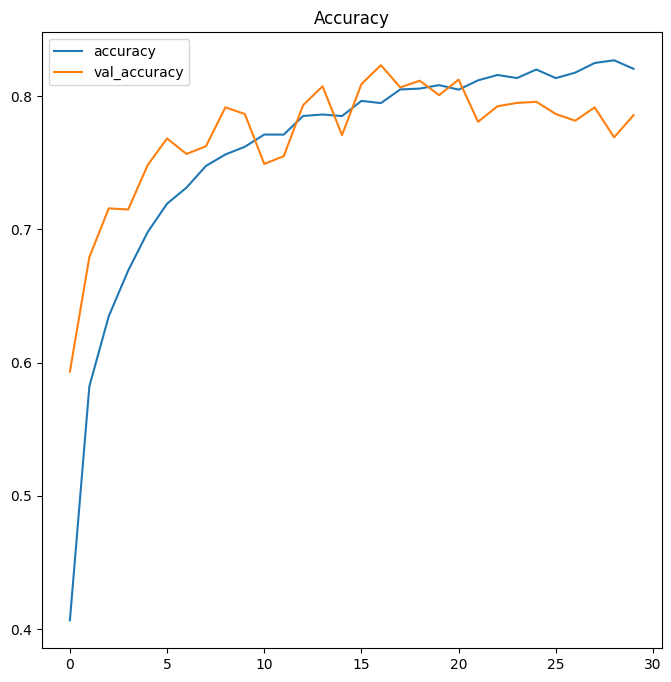

Train accuracy at the end of 50 epochs: 0.8206023573875427
val_accuracy at the end of 50 epochs: 0.7858333587646484


In [ ]:
#Ploting the variation in Train and Validation loss vs Epochs
#Ploting the variation in Train and Validation accuracy vs Epochs

plt.figure(figsize=(8,8))
plt.title('Loss Value')
plt.plot(history_cutmix .history['loss'])
plt.plot(history_cutmix .history['val_loss'])
plt.legend(['loss', 'val_loss'])
print('loss:', history_cutmix .history['loss'][-1])
print('val_loss:', history_cutmix .history['val_loss'][-1])
plt.show()

plt.figure(figsize=(8,8))
plt.title('Accuracy')
plt.plot(history_cutmix .history['accuracy'])
plt.plot(history_cutmix .history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

print('Train accuracy at the end of 30 epochs:', history_cutmix .history['accuracy'][-1])
print('val_accuracy at the end of 30 epochs:', history_cutmix .history['val_accuracy'][-1])

In [ ]:
#Defining function for determining Model performance for DL models
def model_performance_DL(model,X_train,y_train,X_test,y_test,y_test_1):
  #Model is fit on the train set and then used to predict ono Test set
  y_pred = model.predict(X_test)
  predicted=[]
  predicted_prob=y_pred
  for i in range(len(y_pred)):
    predicted.append(np.argmax(y_pred[i]))


  #Different metrics are used to check the model performance
  #Weighted precision,recall,f1_score is reported for all models
  classes = np.unique(y_test_1)
  #y_test_array = pd.get_dummies(y_test, drop_first=False).values
  y_test_array=y_test_1

  accuracy = accuracy_score(y_test_1, predicted)
  print("Accuracy:",  round(accuracy,2))
  #print("Auc:", round(auc,2))
  print("Detail:")
  print(classification_report(y_test_1, predicted))

  ## Plot confusion matrix
  cm = confusion_matrix(y_test_1, predicted)
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots()
  sns.heatmap(cmn, annot=True, fmt='.2f', ax=ax, cmap='YlGnBu',
            )
  ax.set(xlabel="Pred", ylabel="True", xticklabels=classes,
       yticklabels=classes, title="Confusion matrix")
  plt.yticks(rotation=0)

In [ ]:
#Making predictions on the test set for the trtained model
predictions = model_cutmix.predict(X_test)
#Identifying the class with highest probability of prediction
predictions = np.argmax(predictions, axis=1)

#Converting the 1*14 vectors back into interger form
y_test_1 = one_hot_encoder.inverse_transform(y_test)

38/38 [==============================] - 1s 9ms/step


In [ ]:
type(X_test)

numpy.ndarray

38/38 [==============================] - 0s 5ms/step
Accuracy: 0.82
Detail:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       310
           1       0.76      0.56      0.64        45
           2       0.43      0.71      0.53        17
           3       0.83      0.75      0.78        51
           4       0.84      0.93      0.88       111
           5       0.75      0.40      0.52        45
           6       0.90      0.98      0.94       124
           7       0.84      0.86      0.85        50
           8       0.91      0.72      0.80        68
           9       0.68      0.68      0.68        34
          10       0.81      0.98      0.88        47
          11       0.71      0.93      0.80        42
          12       0.74      0.73      0.74       113
          13       0.93      0.79      0.85       143

    accuracy                           0.82      1200
   macro avg       0.78      0.78      0.77      1200
weig

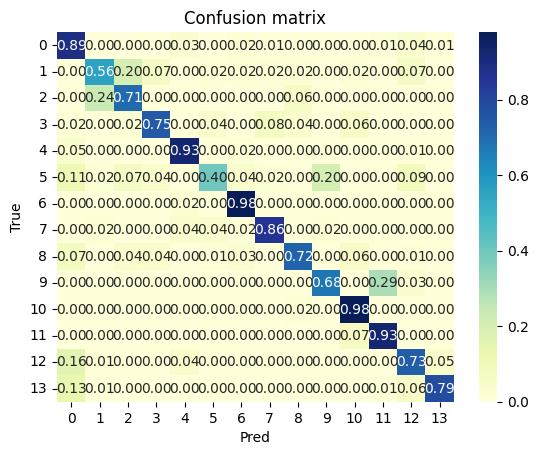

In [ ]:
model_performance_DL(model_cutmix,X_train,y_train,X_test,y_test,y_test_1)

In [ ]:
print('Accuracy Cut-Mix {}'.format(accuracy_score(y_test_1,predictions)))

Accuracy Cut-Mix 0.8233333333333334


In [ ]:
#Saving the Model
model_cutmix.save('my_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


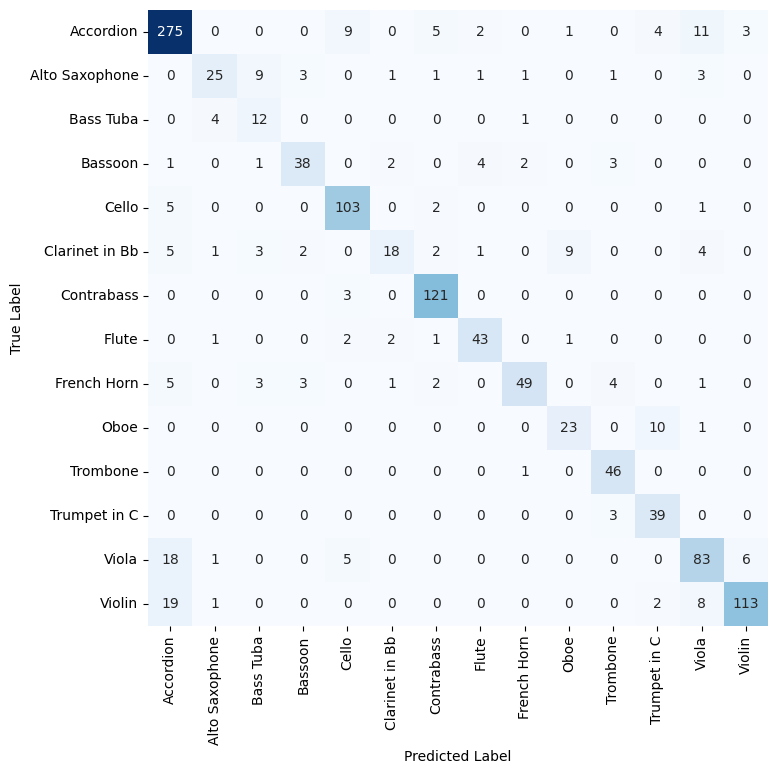

In [ ]:
#Printing the Confusion matrox to visualize the model predictions
#Confusion matrix gives us an idea about the model capabilities

cm = confusion_matrix(y_test_1, predictions)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
label_mapping = {0: 'Accordion', 1: 'Alto Saxophone', 2: 'Bass Tuba', 3: 'Basson',4:'Cello', 5:'Clarinet in Bb', 6:'Contrabass', 7:'Flute', 8:'French Horn', 9:'Oboe', 10:'Trombone', 11:'Trumpet in C', 12:'Viola', 13:'Violin'}
string_labels = [label_mapping[label] for label in predictions]

In [ ]:
string_labels

['Trumpet in C',
 'Basson',
 'Viola',
 'Accordion',
 'Contrabass',
 'Accordion',
 'Violin',
 'Accordion',
 'Contrabass',
 'Accordion',
 'Accordion',
 'Trumpet in C',
 'Flute',
 'Accordion',
 'Accordion',
 'Cello',
 'Cello',
 'Flute',
 'Accordion',
 'French Horn',
 'Violin',
 'Viola',
 'Violin',
 'Contrabass',
 'Flute',
 'Accordion',
 'Alto Saxophone',
 'Accordion',
 'Contrabass',
 'Viola',
 'Cello',
 'Contrabass',
 'Bass Tuba',
 'Accordion',
 'Contrabass',
 'Accordion',
 'Violin',
 'Cello',
 'Violin',
 'Accordion',
 'Accordion',
 'Alto Saxophone',
 'Accordion',
 'Flute',
 'Clarinet in Bb',
 'Viola',
 'Violin',
 'Accordion',
 'Cello',
 'French Horn',
 'Basson',
 'Oboe',
 'Contrabass',
 'Contrabass',
 'Accordion',
 'Trumpet in C',
 'Clarinet in Bb',
 'French Horn',
 'Accordion',
 'Flute',
 'French Horn',
 'Viola',
 'Viola',
 'Viola',
 'Accordion',
 'Clarinet in Bb',
 'Viola',
 'Accordion',
 'Clarinet in Bb',
 'Basson',
 'Viola',
 'Trumpet in C',
 'Flute',
 'Trombone',
 'Basson',
 'Violin

## Custom Dataset Class

In [ ]:
#Creating a Custom Dataset Class
from keras.models import load_model
import os

class CustomDataset:
    def __init__(self, csv_file, audio_folder, model):
        self.data = pd.read_csv(csv_file)
        self.audio_folder = audio_folder
        self.model = model

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        audio_filename = self.data.iloc[idx]['Path']
        # audio_path = os.path.join(self.audio_folder, audio_filename)

        # Load audio file
        audio, sr = librosa.load(audio_filename, sr=None)
        bit = len(audio)
        # Compute Mel spectrogram
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)

        # Reshape audio and mel spectrogram
        audio = audio.reshape(1, -1)
        mel_spectrogram = mel_spectrogram.reshape(1, mel_spectrogram.shape[0], mel_spectrogram.shape[1])

        # Get ground truth label
        ground_truth = self.data.iloc[idx]['Instrument (in full)']


        self.data['bit_length'] = pd.Series()
        self.data['audio_waves'] = pd.Series()
        self.data.iloc[idx]['bit_length'] = bit
        self.data.iloc[idx]['audio_waves'] = audio
                # Sample segment from audio data
        min_bits = 49657
        bit_lengths = len(audio)  # Length of audio in bits


          # Check if bit_lengths is greater than or equal to min_bits
        if bit_lengths >= min_bits:
          chosen_initial = np.random.choice(np.arange(0, bit_lengths - min_bits))
        else:
    # Handle the case where bit_lengths is smaller than min_bits
    # For example, you could set chosen_initial to 0 or another suitable value
          chosen_initial = 0  # Adjust as needed


        # Slice the audio waves to obtain the desired segment
        generated_audio_waves = audio[chosen_initial:chosen_initial+min_bits]


        # # chosen_file = np.random.choice(self.data["Path"].values)
        # bit_lengths = self.data[self.data["Path"]==audio_filename]['bit_length'].values
        # min_bit_length = min_bits
        # offset_bit_length = bit_lengths - min_bit_length
        # chosen_initial = np.random.choice(np.arange(0, len(offset_bit_length)))

        # generated_audio_waves = self.data[self.data["Path"]==audio_filename]['audio_waves'].values[0][chosen_initial:chosen_initial+min_bits]
        audio_m = mfcc(generated_audio_waves)

        audio_m = audio_m.reshape(1,audio_m.shape[0], audio_m.shape[1],1)
        # Perform model prediction to generate pseudo label
        pseudo_label = self.model.predict(audio_m)  # 1 hot encoded

        label_mapping = {0: 'Accordion', 1: 'Alto Saxophone', 2: 'Bass Tuba', 3: 'Basson',4:'Cello', 5:'Clarinet in Bb', 6:'Contrabass', 7:'Flute', 8:'French Horn', 9:'Oboe', 10:'Trombone', 11:'Trumpet in C', 12:'Viola', 13:'Violin'}
        string_label = [label_mapping[label] for label in pseudo_label]
        # Return dictionary with required items
        return {
            'file': audio_filename,
            'audio': audio_m,
            'mel': mel_spectrogram,
            'gt': ground_truth,
            'pseudo': string_label
        }



In [ ]:
#Using the Class
# Define paths and filenames
csv_file = '/content/TinySOL_metadata.csv'
audio_folder = '/content'
model_file = 'my_model.h5'

# Load the trained model
model = load_model(model_file)

# Instantiate the custom dataset
dataset = CustomDataset(csv_file, audio_folder, model)

# Access data from the dataset
# Example 1: Access data for the first sample
sample_data = dataset[2]
print(len(sample_data['audio']))

<ipython-input-112-979051748e1c>:32: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.data['bit_length'] = pd.Series()
<ipython-input-112-979051748e1c>:33: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.data['audio_waves'] = pd.Series()
<ipython-input-112-979051748e1c>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.data.iloc[idx]['bit_length'] = bit
<ipython-input-112-979051748e1c>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

TypeError: only integer scalar arrays can be converted to a scalar index